**Brain Tumor Detection**

Dataset: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data (7,023 images)

In [ ]:
pip install kagglehub

In [ ]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans


Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 99% 234M/236M [00:10<00:00, 20.7MB/s]
100% 236M/236M [00:10<00:00, 24.3MB/s]


In [ ]:
!unzip /content/brain-tumor-mri-scans.zip -d /content/brain-tumor-mri-scans/


Streaming output truncated to the last 5000 lines.
  inflating: /content/brain-tumor-mri-scans/healthy/0402.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0403.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0404.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0405.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0406.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0407.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0408.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0409.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0410.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0411.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0412.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0413.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0414.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0415.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0416.jpg  
  in

In [ ]:
import os
dataset_path = '/content/brain-tumor-mri-scans/'

# List the folders inside the dataset directory
print(os.listdir(dataset_path))


['healthy', 'meningioma', 'pituitary', 'glioma']


In [ ]:
from PIL import Image

image_dir = "/content/brain-tumor-mri-scans/"  # Change to the actual path

# Categories
categories = ["glioma", "healthy", "meningioma", "pituitary"]

# Function to check image integrity
def check_image_integrity(image_dir):
    corrupted_files = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if the image is readable
        except (IOError, SyntaxError) as e:
            corrupted_files.append(img_file)
    return corrupted_files

# Iterate through each category and check for corrupted images
for category in categories:
    category_path = os.path.join(image_dir, category)
    corrupted = check_image_integrity(category_path)
    if corrupted:
        print(f"Corrupted images in {category}: {corrupted}")
        # Remove corrupted files
        for corrupted_img in corrupted:
            os.remove(os.path.join(category_path, corrupted_img))
    else:
        print(f"No corrupted images in {category}")


No corrupted images in glioma
No corrupted images in healthy
No corrupted images in meningioma
No corrupted images in pituitary


In [ ]:
import numpy as np

# Function to normalize images: After resizing, normalize the pixel values of the images to the range [0, 1].
def normalize_images(image_dir, target_size=(128, 128)):
    images = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path).resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)

# Normalize images in each category
all_images = []
labels = []

for i, category in enumerate(categories):
    category_path = os.path.join(image_dir, category)
    images = normalize_images(category_path)
    all_images.append(images)
    labels.extend([i] * len(images))  # Assign label based on the category

# Convert lists to numpy arrays for future model training
all_images = np.concatenate(all_images, axis=0)
labels = np.array(labels)

print("Image data and labels prepared.")


Image data and labels prepared.


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 5618
Test set size: 1405


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define the original dataset directory and the new directories for train and test sets
original_dataset_dir = "/content/brain-tumor-mri-scans"
train_dir = "/content/brain-tumor-mri-scans-train"
test_dir = "/content/brain-tumor-mri-scans-test"

# Create new directories for train and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load all images and labels
all_images = []
labels = []

for category in os.listdir(original_dataset_dir):
    category_path = os.path.join(original_dataset_dir, category)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                all_images.append(img_path)
                labels.append(category)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.2, random_state=42)

# Function to copy images to the new directories
def copy_images(file_paths, labels, dest_dir):
    for img_path, label in zip(file_paths, labels):
        label_dir = os.path.join(dest_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

# Copy images to train and test directories
copy_images(X_train, y_train, train_dir)
copy_images(X_test, y_test, test_dir)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 5618
Test set size: 1405


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np

# Define the data directory
data_dir = "/content/brain-tumor-mri-scans-train"
data_dir_test="/content/brain-tumor-mri-scans-test"
# Load the dataset
train_dataset = image_dataset_from_directory(
    #os.path.join(data_dir, 'train'),
    data_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='int'  # Use 'categorical' for one-hot encoding directly
)

validation_dataset = image_dataset_from_directory(
    data_dir_test,
    image_size=(128, 128),
    batch_size=32,
    label_mode='int'
)

# Separate images and labels
X_train = []
y_train = []
for images, labels in train_dataset:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_test = []
y_test = []
for images, labels in validation_dataset:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

 # One-hot encode the labels
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

# Define the more complex CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(lb.classes_), activation='softmax')  # Number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

print(f"Test accuracy: {test_accuracy:.2f}")


Found 5618 files belonging to 4 classes.
Found 1405 files belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.5177 - loss: 1.4201 - val_accuracy: 0.6185 - val_loss: 1.2971
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.7263 - loss: 0.7529 - val_accuracy: 0.5594 - val_loss: 1.9083
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.7882 - loss: 0.5383 - val_accuracy: 0.6363 - val_loss: 1.2997
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.8299 - loss: 0.4496 - val_accuracy: 0.7687 - val_loss: 0.7012
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.8496 - loss: 0.4050 - val_accuracy: 0.4327 - val_loss: 1.7840
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.8673 - loss: 0.3558 - val_accuracy: 0.7288 - val_loss: 1.7669
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8908 - loss: 0.3184 - val_accuracy: 0.7217 - val_loss: 1.3575
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9021 - loss: 0.2664 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 433ms/step
F1 Score (weighted): 0.94
AUC-ROC Score: 0.99


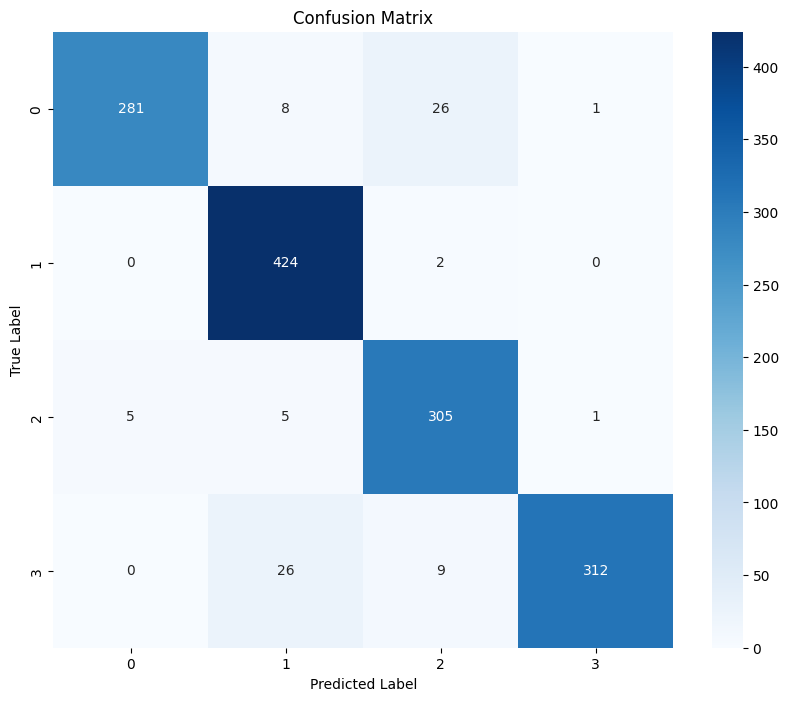

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93       316
           1       0.92      1.00      0.95       426
           2       0.89      0.97      0.93       316
           3       0.99      0.90      0.94       347

    accuracy                           0.94      1405
   macro avg       0.95      0.94      0.94      1405
weighted avg       0.94      0.94      0.94      1405

36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 387ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 386ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 388ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 385ms/step
Cross-Validation Accuracy: 0.9681371073288061
Cross-Validation F1 Score: 0.9680563638914368
Cross-Validation ROC AUC Score: 0.9891810890144986


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold

# Get the model predictions on the test set (no retraining)
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted classes
y_true = np.argmax(y_test_encoded, axis=1)  # True classes

# 1. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.2f}")

# 2. AUC-ROC
try:
    roc_auc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr')
    print(f"AUC-ROC Score: {roc_auc:.2f}")
except ValueError:
    print("AUC-ROC calculation is not possible for multiclass classification without one-hot encoded labels.")

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4. Classification Report
# Ensure lb.classes_ is a list or array of strings, not integers
if isinstance(lb.classes_, np.ndarray):
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=lb.classes_.astype(str)))
else:
    print("Error: lb.classes_ is not an ndarray. Please check the LabelBinarizer setup.")

# 5. Cross-Validation (Using K-Fold on Training Data)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
cv_f1_scores = []
cv_roc_aucs = []

# No retraining of model here, just evaluation
for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train_encoded[train_index], y_train_encoded[val_index]

    # Evaluate on the validation fold using the trained model
    val_predictions = model.predict(X_val_cv)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    y_val_classes = np.argmax(y_val_cv, axis=1)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_val_classes, val_pred_classes)
    f1 = f1_score(y_val_classes, val_pred_classes, average="weighted")
    try:
        roc_auc = roc_auc_score(y_val_cv, val_predictions, multi_class="ovr")
    except ValueError:
        roc_auc = None

    cv_accuracies.append(accuracy)
    cv_f1_scores.append(f1)
    if roc_auc is not None:
        cv_roc_aucs.append(roc_auc)

# Print the cross-validation results
print("Cross-Validation Accuracy:", np.mean(cv_accuracies))
print("Cross-Validation F1 Score:", np.mean(cv_f1_scores))
if cv_roc_aucs:
    print("Cross-Validation ROC AUC Score:", np.mean(cv_roc_aucs))
else:
    print("Cross-Validation ROC AUC Score: Not available for all folds")
